In [ ]:
!pip install astroquery

     |████████████████████████████████| 4.5 MB 18.2 MB/s 
     |████████████████████████████████| 832 kB 56.2 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 3.6 MB 49.8 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy import units as u

from astroquery.gaia import Gaia
from astropy.io.votable import parse

pd.options.mode.chained_assignment = None

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

## Getting data from Gaia edr3

In [ ]:
# user_name= 'sortiz01'
# Gaia.login(user= user_name)

In [ ]:
# m=100000 #stars limit amount
# query= f"""
#     SELECT TOP {m}
#     source_id, ra, dec,l,b, parallax, parallax_over_error, pmra, pmra_error, pmdec, pmdec_error,
#     dr2_radial_velocity, dr2_radial_velocity_error, 1000/parallax as dist
#     FROM gaiaedr3.gaia_source
#     WHERE parallax>0 AND 1000/parallax<1000
    
#     """

In [ ]:
# job= Gaia.launch_job_async(query)
# results= job.get_results().to_pandas()
# len(results)

In [ ]:
results= votable_to_pandas('/content/drive/MyDrive/Colab Notebooks/Mineria de Datos/proyecto_final/muestra.gz') #toma alrededor de 1 minuto leer el archivo

## Cleaning data

In [ ]:
results.dropna(inplace=True)

In [ ]:
gaia_results= results.query('(dr2_radial_velocity_error/dr2_radial_velocity<0.1) & (pmra_error/pmra<0.1) & (pmdec_error/pmdec<0.1) & (parallax_over_error)>10')

len(gaia_results)

4908

## group by dist

In [ ]:
gaia_results.head()

,source_id,ra,dec,l,b,parallax,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,dr2_radial_velocity,dr2_radial_velocity_error,dist
33,6021082422829909248,250.161297,-34.163720,347.633482,8.149462,1.290959,91.767616,-0.494771,0.017258,-8.005556,0.014196,-8.805074,0.231687,774.618189
122,6021016314692651136,250.920154,-33.883226,348.261763,7.854231,9.100075,729.378723,14.307841,0.016203,22.066722,0.012630,47.931747,1.268554,109.889202
293,6020960480117803776,251.396573,-33.906767,348.501047,7.536882,1.996260,118.429955,1.277408,0.023288,-10.185112,0.016822,-3.423550,1.226088,500.936749
295,6020960480119228544,251.400586,-33.911921,348.499226,7.531017,1.143461,67.512779,0.616991,0.021916,-3.724511,0.016577,34.541943,1.092638,874.538164
474,6021016662614146176,250.951191,-33.880874,348.280400,7.836105,2.478233,162.650269,-25.703248,0.019419,-20.146844,0.014547,-77.479828,1.733676,403.513307


In [ ]:
rs= np.arange(0,1000,50)
shells= []

for i in range(1,len(rs)):
  shells.append(gaia_results[(gaia_results['dist']>rs[i-1]) & (gaia_results['dist']<rs[i])])

In [ ]:
rs

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950])

## Exploring proper motion

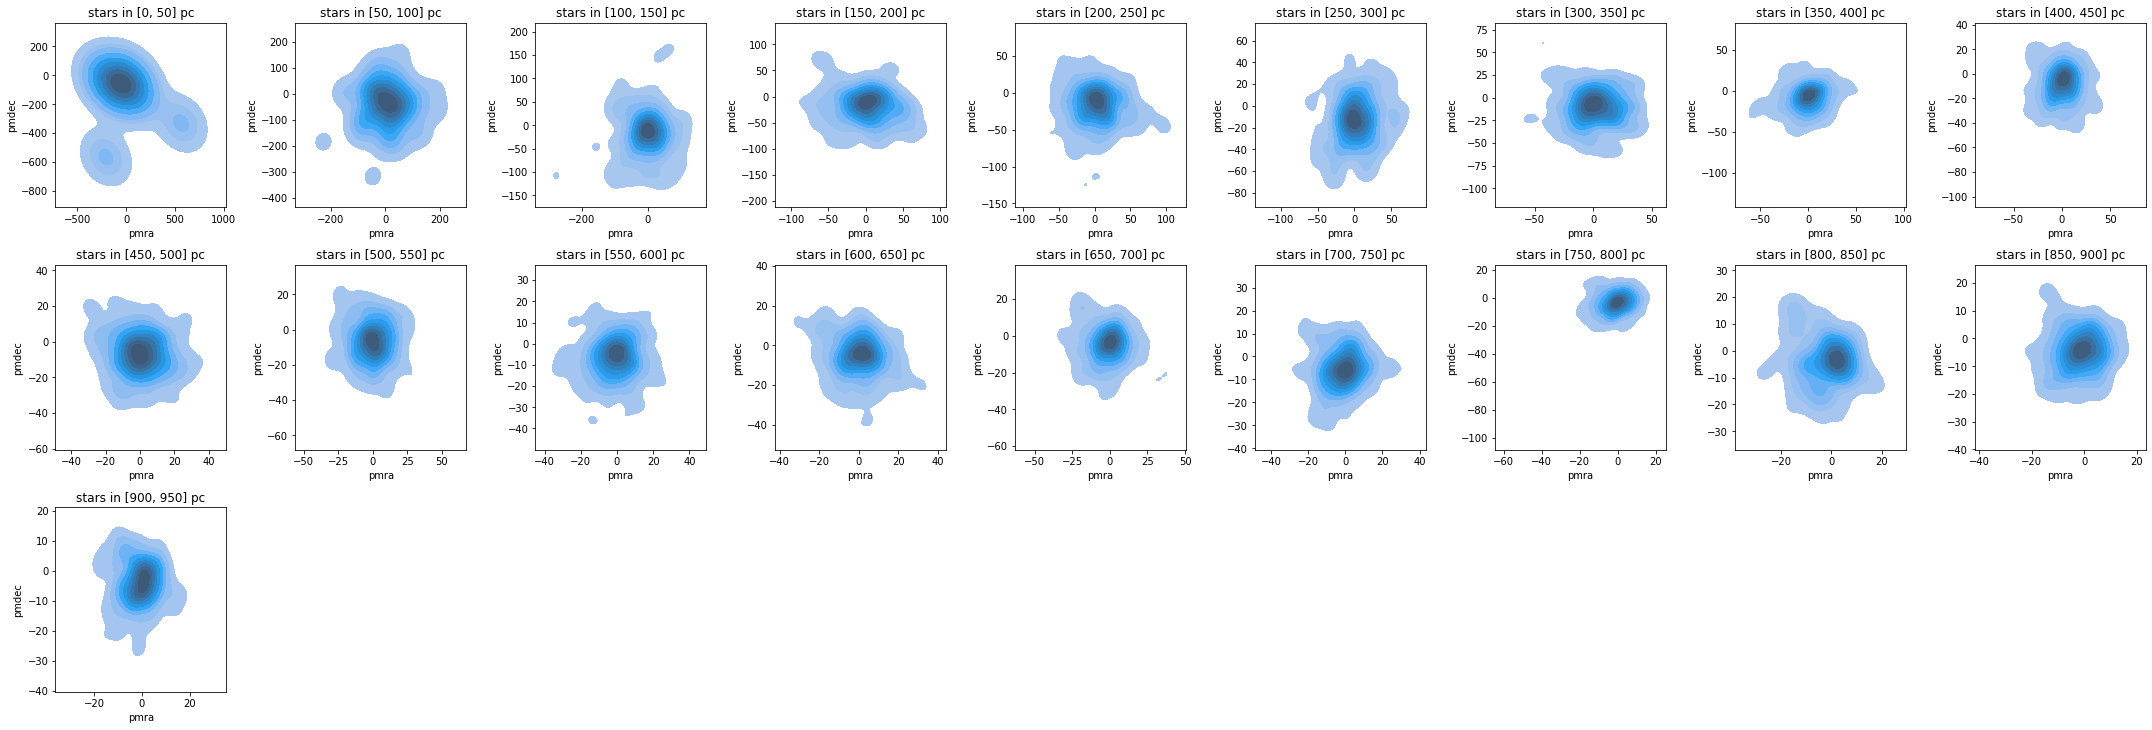

In [ ]:
plt.figure(figsize=(30,30))
plt.title('proper motion distribution')

for j,shell in enumerate(shells):
  ax= plt.subplot(int(len(shells)/2),int(len(shells)/2), j+1)
  ax.set_title(f'stars in [{rs[j]}, {rs[j+1]}] pc')
  sns.kdeplot(data=shell, x='pmra', y='pmdec', fill=True, ax=ax)
  

plt.tight_layout()
plt.show()

## Proper motion distribution by shells and coords

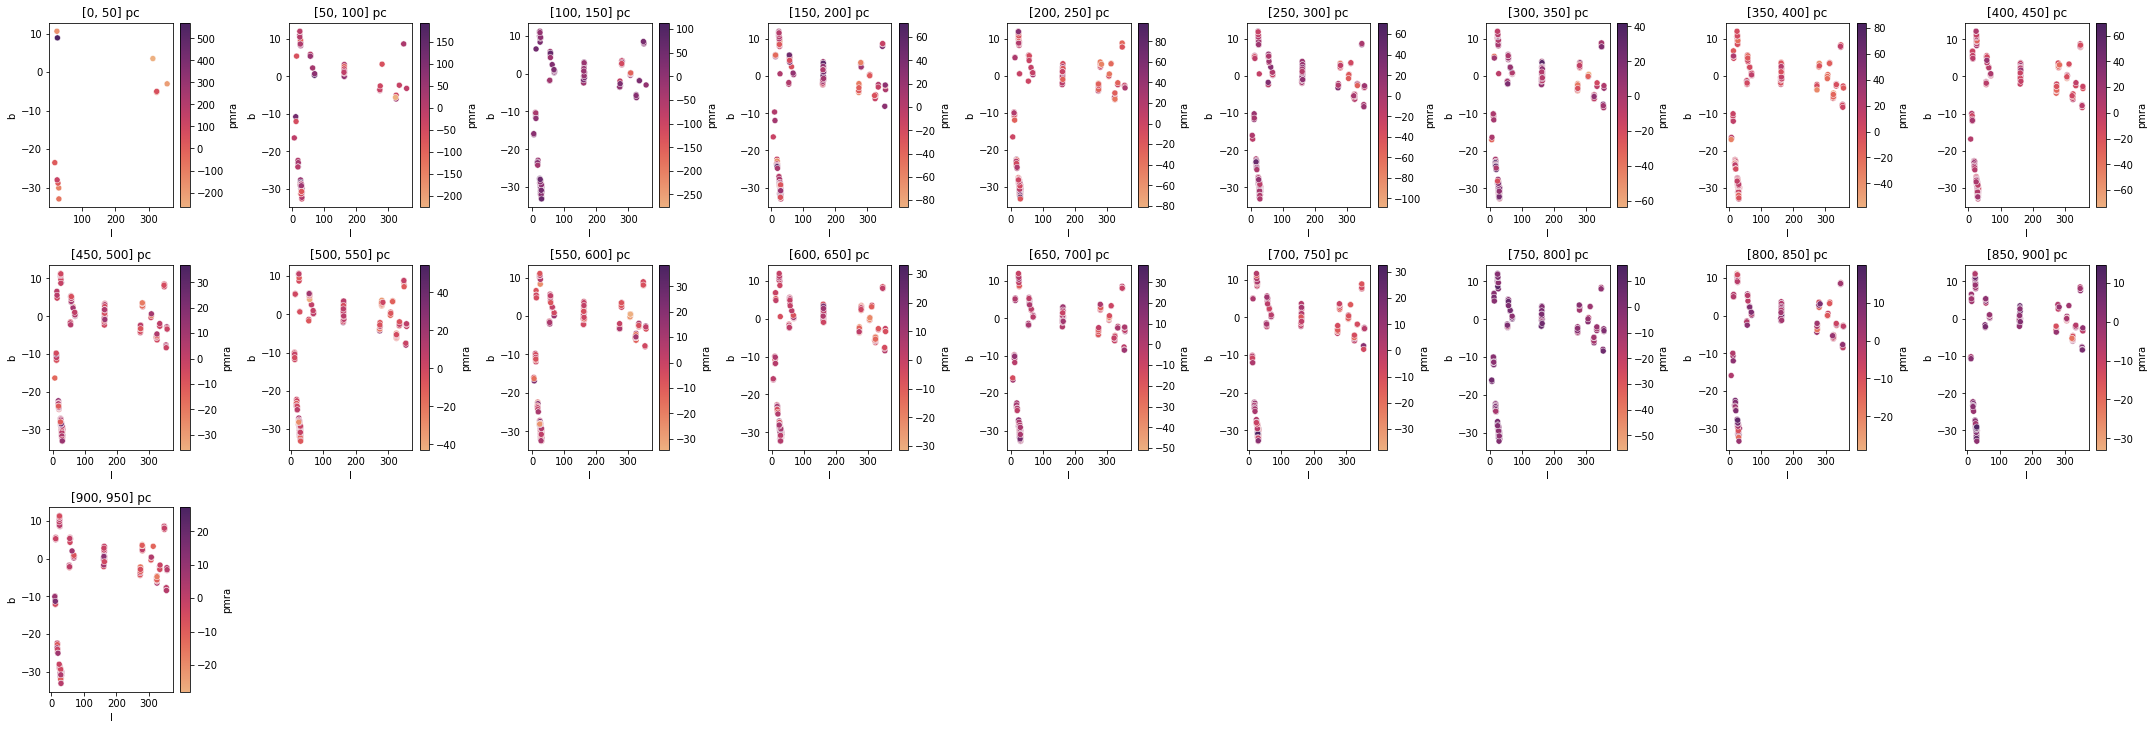

In [ ]:
plt.figure(figsize=(30,30))

for j,shell in enumerate(shells):
  ax= plt.subplot(int(len(shells)/2),int(len(shells)/2), j+1)
  ax.set_title(f'[{rs[j]}, {rs[j+1]}] pc')
  
  norm = plt.Normalize(shell['pmra'].min(), shell['pmra'].max())
  cb = plt.cm.ScalarMappable(cmap="flare", norm=norm)

  sns.scatterplot(data= shell, x= 'l', y='b', hue='pmra', palette='flare')

  ax.legend().set_visible(False)
  ax.figure.colorbar(cb, label='pmra')

plt.tight_layout()
plt.show()

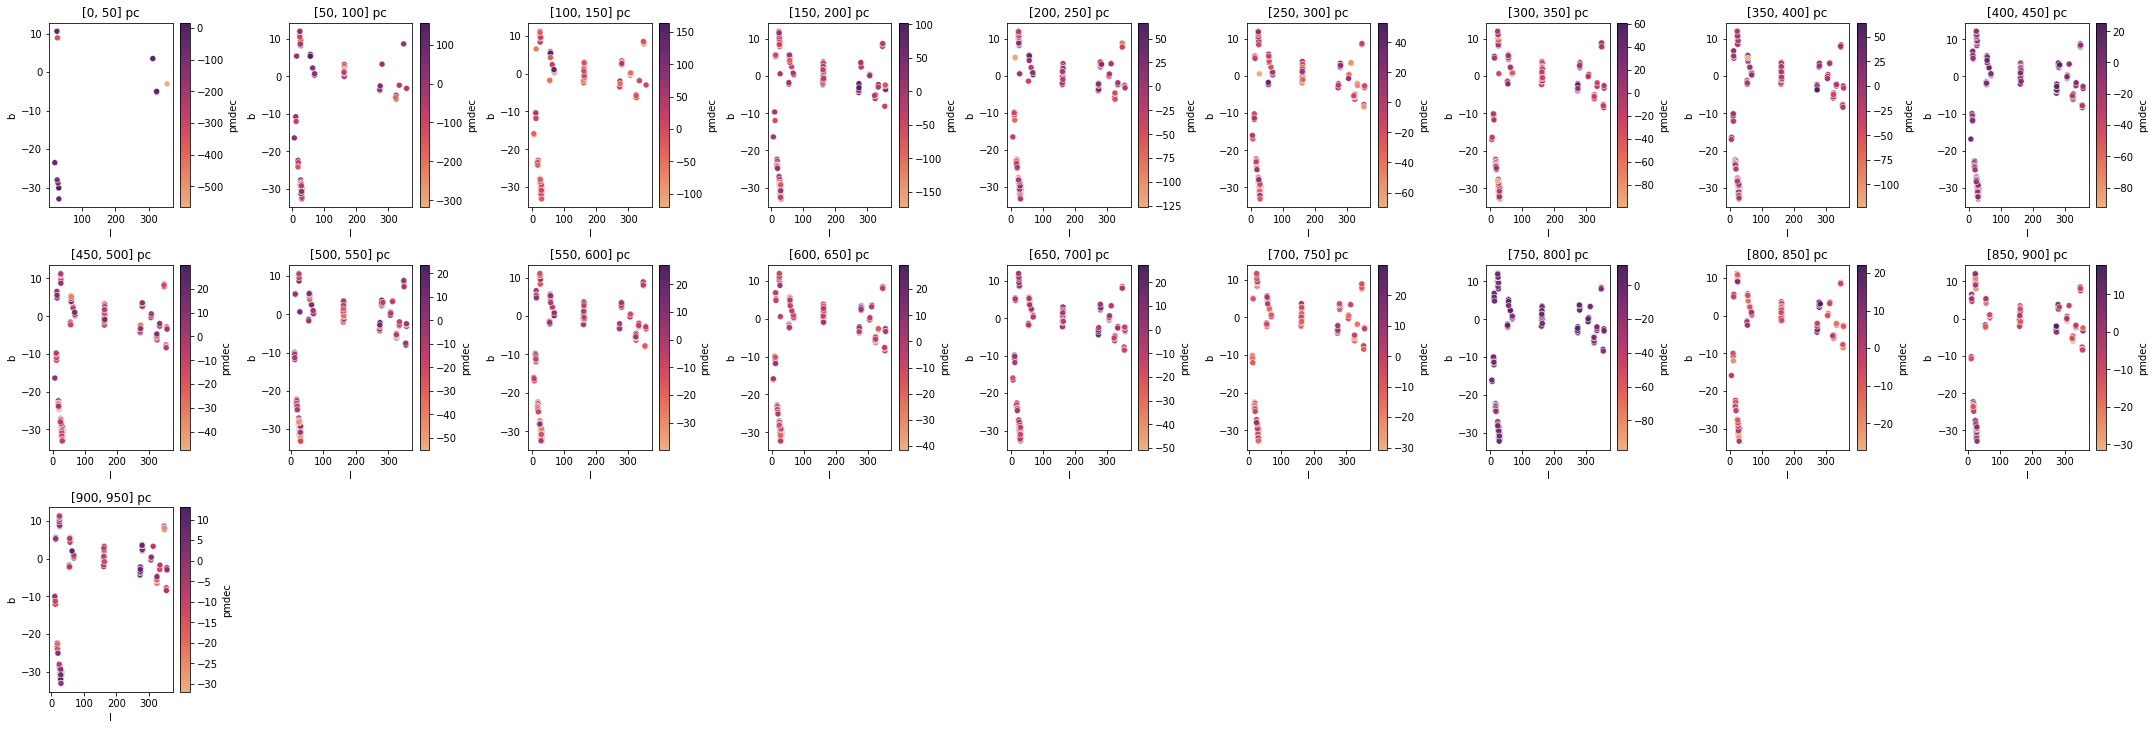

In [ ]:
plt.figure(figsize=(30,30))

for j,shell in enumerate(shells):
  ax= plt.subplot(int(len(shells)/2),int(len(shells)/2), j+1)
  ax.set_title(f'[{rs[j]}, {rs[j+1]}] pc')
  
  norm = plt.Normalize(shell['pmdec'].min(), shell['pmdec'].max())
  cb = plt.cm.ScalarMappable(cmap="flare", norm=norm)

  sns.scatterplot(data= shell, x= 'l', y='b', hue='pmdec', palette='flare')
  ax.legend().set_visible(False)
  ax.figure.colorbar(cb, label='pmdec')

plt.tight_layout()
plt.show()

## Enfoque en el primer cascaron. Se toman todas las estrellas en gedr3dist.main con r_med_geo<100 (tap search)

SELECT * FROM external.gaiaedr3_distance WHERE r_med_geo<100

Con estas se hace un JOIN con el gaiaedr3.gaia_sources para obtener parallax, parallax_over_error and coordinates

In [ ]:
results= votable_to_pandas('/content/drive/MyDrive/Colab Notebooks/Mineria de Datos/proyecto_final/within100pc.gz') #toma alrededor de 1 minuto leer el archivo
len(results)

485274

## Filtros

In [ ]:
results.dropna(inplace=True)
len(results)

73007

## Stars with dr2_radial_velocity_error, pmra_error, pmdec_error and parallax_error greater than 10% are left out.

In [ ]:
results.query('(dr2_radial_velocity_error/dr2_radial_velocity<0.1) & (pmra_error/pmra<0.1) & (pmdec_error/pmdec<0.1) & (parallax_over_error)>10', inplace=True)
len(results)

63484

## Building average proper motion fields

## Sky grid

In [ ]:
results.head()

,source_id,ra,dec,l,b,parallax,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,dr2_radial_velocity,dr2_radial_velocity_error,r_med_geo,r_lo_geo,r_hi_geo
10,6553614253923452800,346.503917,-35.847164,5.097226,-65.987693,304.135369,15210.014648,6765.995136,0.020219,1330.285275,0.016432,8.172910,0.144854,3.287725,3.287493,3.287920
12,1872046574983497216,316.753663,38.756073,82.339880,-5.830396,286.005352,9882.616211,4105.976428,0.025808,3155.941640,0.026797,-64.425049,0.130154,3.496067,3.495700,3.496407
13,1872046609345556480,316.748479,38.763862,82.342974,-5.822177,285.994948,4774.756836,4164.208692,0.055290,3249.613884,0.055023,-65.937759,0.135712,3.496246,3.495627,3.497006
17,385334230892516480,4.613226,44.024787,116.690592,-18.446865,280.706822,13838.454102,2891.518077,0.015489,411.832020,0.013023,11.511070,0.135930,3.562003,3.561772,3.562263
19,6412595290592307840,330.872408,-56.797255,336.165620,-48.055440,274.843142,2874.477539,3966.660539,0.085571,-2536.191987,0.092213,-40.504478,0.230185,3.638480,3.637340,3.640133


## Building spheric cubes

In [ ]:
class Cube:
  def __init__(self, id, li, lf,bi,bf, ri,rf):
    self.id = id
    self.li = li
    self.lf = lf
    self.bi = bi
    self.bf = bf
    self.ri = ri
    self.rf = rf
    self.stars = pd.DataFrame()
    self.avgpmra= pd.NA
    self.avgpmdec= pd.NA
    self.pmra_outliers= pd.DataFrame()
    self.pmdec_outliers= pd.DataFrame()
    self.std

In [ ]:
nl= 30 #particiones por intervalo
nb= 30
nr= 10

ls= np.linspace(0,360,nl) 
bs= np.linspace(0,180,nb)

length_l= 360/nl

def rf(thetai, thetaf, ri):
  k=np.radians(length_l)*(np.sin(np.radians(thetaf)-np.sin(np.radians(thetai))))
  V= 100**3/3 * k
  return (3*(V/(nr-1))/k + ri**3)**(1/3)

cubes=[0]*((nl-1)*(nb-1)*(nr-1))

cubes_frontera=[0]*nr
cubes_frontera[0]=Cube(0, ls[0], ls[1], bs[0], bs[1], 0,0)


counter=0
for i in range(nr-1):
  for j in range(nb-1):
    for k in range(nl-1):
      cubes[counter]=Cube(counter, ls[k] , ls[k+1], bs[j], bs[j+1], cubes_frontera[i].rf, rf(bs[j], bs[j+1],cubes_frontera[i].rf))
      counter+=1
  cubes_frontera[i+1]= cubes[counter-1]

## Now, we need to add each star to its cube.

The filters by distance only works if the angular lengths of the spheric cube are small enough. If this condition isn't met, errors could appear.

In [ ]:
for cube in cubes:
  cube.stars = results.query(f'l<{cube.lf} & l>{cube.li} & b<{cube.bf} & b>{cube.bi} & r_med_geo<{cube.rf} & l>{cube.ri}')
  cube.stars['cube_id']= cube.id
  cube.avgpmra = cube.stars.pmra.mean()
  cube.avgpmdec = cube.stars.pmdec.mean()

## Once each cube has its stars, we build the average pmra (pmdec) field

## pregunta, ¿basta simplemente con tomar el promedio del pmra y del pmrdec en cada cubo sin tener en cuenta la dirección?

## Test

In [ ]:
#cube with greatest length
lengths= np.array([ len(cube.stars) for cube in cubes])
np.argmax(lengths)

6783

In [ ]:
from astropy.coordinates import spherical_to_cartesian

In [ ]:
test0= cubes[200].stars
test0.reset_index(inplace=True)

test1= cubes[5200].stars
test1.reset_index(inplace=True)

In [ ]:
xs0,ys0,zs0= spherical_to_cartesian(test0.r_med_geo, np.radians(test0.b), np.radians(test0.l))
xs1,ys1,zs1= spherical_to_cartesian(test1.r_med_geo, np.radians(test1.b), np.radians(test1.l))

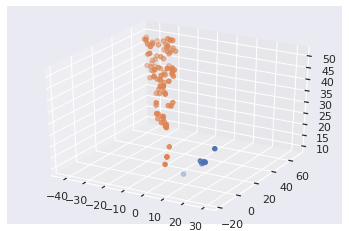

In [ ]:
plt.figure()
ax= plt.axes(projection='3d')
ax.scatter(xs0.value,ys0.value,zs0.value)
ax.scatter(xs1.value,ys1.value,zs1.value)

## Deviations respect to mean in each cube

## pregunta, ¿esta es la forma correcta de calcular la desviación?

In [ ]:
for cube in cubes:
  cube.stars['pmra_deviation'] = cube.avgpmra - cube.stars.pmra
  cube.stars['pmdec_deviation'] = cube.avgpmdec - cube.stars.pmdec

## Visualización de las desviaciones

In [ ]:
from scipy.stats import norm

In [ ]:
for cube in cubes:
  if len(cube.stars)!=0:
    ura,stdra= norm.fit(cube.stars['pmra_deviation'])
    udec,stddec= norm.fit(cube.stars['pmdec_deviation'])
    cube.pmra_outliers= cube.stars.query(f'pmra_deviation<{ura-3*stdra} | pmra_deviation>{ura+3*stdra}')
    cube.pmdec_outliers= cube.stars.query(f'pmra_deviation<{udec-3*stddec} | pmra_deviation>{udec+3*stddec}')

In [ ]:
# #pmra sigue distribución normal
# dist= cubes[1101].stars
# plt.figure()
# sns.histplot(data=dist, x='pmra_deviation',kde=True)

In [ ]:
pmra_outliers= pd.concat([ cube.pmra_outliers for cube in cubes],axis=0)
pmdec_outliers= pd.concat([ cube.pmdec_outliers for cube in cubes],axis=0)

In [ ]:
len(pmra_outliers), len(pmdec_outliers)

(2062, 4164)

In [ ]:
len(list(set(pmra_outliers.source_id) & set(pmdec_outliers.source_id)))

337

In [ ]:
common= pd.DataFrame(list(set(pmra_outliers.source_id) & set(pmdec_outliers.source_id)), columns=['source_id'])

In [ ]:
pd.merge(common,results, on=['source_id'])

,source_id,ra,dec,l,b,parallax,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,dr2_radial_velocity,dr2_radial_velocity_error,r_med_geo,r_lo_geo,r_hi_geo
0,2197526687087648768,314.746882,65.044305,101.411819,12.418538,12.695288,205.055069,-369.552641,0.074673,-38.493080,0.073572,-89.502495,2.869374,78.584846,78.189735,78.973251
1,3562962623740696576,167.891309,-14.994032,270.001894,41.404506,51.874836,78.594452,693.071554,0.590328,-599.182036,0.518437,-11.830866,1.118468,19.274328,19.071608,19.485964
2,6009538585839374336,236.868913,-37.917263,337.160870,12.988964,65.588895,1916.790405,-415.506578,0.038759,-213.990938,0.023603,-6.737642,0.161611,15.236676,15.229421,15.246193
3,5684037136313018368,145.935720,-17.784076,252.186421,26.073176,74.584545,3887.386963,-1419.969590,0.021152,226.091208,0.017923,95.753433,0.888099,13.407547,13.404390,13.411070
4,1225071530636576768,213.123222,10.149458,355.153829,64.447709,28.794083,2006.312378,-574.323028,0.015806,76.134472,0.014005,-40.333572,3.996865,34.670559,34.651596,34.687866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,6104435819513399168,215.343330,-40.394254,320.908606,19.317207,35.457734,1601.416992,-561.734223,0.028899,-68.339019,0.022350,4.481666,0.445975,28.180853,28.163761,28.194645
333,3936909723803146496,199.217828,17.015464,334.418122,78.301770,90.947500,3923.926025,649.665527,0.030546,-263.936591,0.026127,5.778536,0.496670,10.990408,10.988043,10.992805
334,3738099879558957952,202.504202,10.372390,333.237913,70.938394,131.101345,4863.854004,1127.340533,0.027238,-1073.888136,0.013986,14.050164,0.209607,7.625603,7.623923,7.627517
335,3914019231742221568,170.931215,8.564345,250.663727,62.165306,49.580895,2616.778809,-1003.372952,0.020903,193.093572,0.019689,54.973358,0.401642,20.151798,20.144598,20.160664


## Entonces, por ahora: se tienen las estrellas que son outliers tanto en pmra como en pmdec respecto a su cube. ¿Qué sigue? ¡descansar!